In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image # 图像的读写显的库
from mpl_toolkits.mplot3d import Axes3D
from time import time
from scipy import misc

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin  # 计算点与点直接的最小距离，然后将最小距离的点组成一个key/value的键值对
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

In [3]:
## 解决展示的时候中文乱码
matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

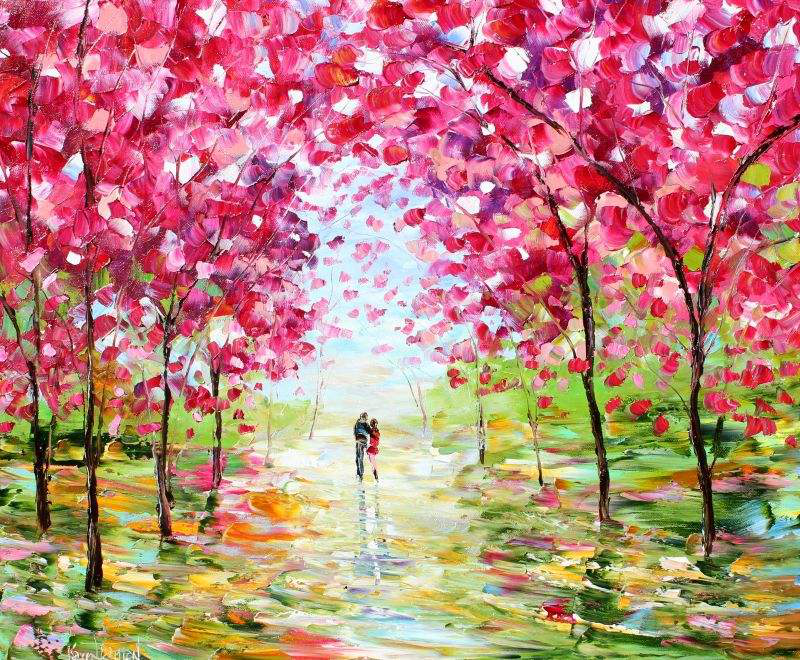

In [29]:
# 分成了128个像素等级
n_colors = 128
image = Image.open('./datas/image.jpg') 
image

In [30]:
#将数据转换为RGB的百分比
image = np.array(image, dtype=np.float64) / 255
#获取图片数据的维度/形状（长、宽、像素）
original_shape = tuple(image.shape)
print('original image shape', original_shape)
shape_size = len(original_shape)

# d设置为1是为了黑白图片的显示
w, h, d = original_shape[0], original_shape[1], 1
if shape_size == 3:
    d = original_shape[2]

original image shape (660, 800, 3)


In [31]:
#将图片数据设置为二维的
image_v = np.reshape(image, (w * h, d))
print("image_v's shape:", image_v.shape)
image_v

image_v's shape: (528000, 3)


array([[0.90196078, 0.52156863, 0.59607843],
       [0.74509804, 0.38823529, 0.45490196],
       [0.92941176, 0.60392157, 0.66666667],
       ...,
       [0.59607843, 0.51764706, 0.18039216],
       [0.58823529, 0.52156863, 0.17647059],
       [0.60392157, 0.54509804, 0.18823529]])

In [32]:
# 打乱顺序后 选择前10000个数据
image_v_sample = shuffle(image_v, random_state=28)[:10000]
print("image_v's shape:", image_v_sample.shape)
image_v_sample

image_v's shape: (10000, 3)


array([[0.60392157, 0.80784314, 0.31372549],
       [0.95294118, 0.35686275, 0.51764706],
       [0.73333333, 0.92156863, 0.59215686],
       ...,
       [0.80392157, 0.15686275, 0.37647059],
       [0.10980392, 0.09411765, 0.09019608],
       [0.68627451, 0.18431373, 0.37647059]])

In [33]:
# 算法构建 即对图像中前10000个像素点进行聚类，聚成128个簇
t0 = time()
k_means = KMeans(n_clusters=n_colors, random_state=28)
k_means.fit(image_v_sample)
print ("模型构建消耗时间:%.3fs" % (time() - t0))

模型构建消耗时间:11.023s


In [34]:
# 进行算法数据预测，得到图片对应的所有的聚类类别信息
t0 = time()
labels = k_means.predict(image_v)
print ("算法模型预测消耗时间:%.3fs" % (time() - t0))

算法模型预测消耗时间:0.599s


In [35]:
# 进行随机数据抽取，得到图片对象的聚类的类别信息
t0 = time()
codebook_random = shuffle(image_v, random_state=28)[:n_colors]  # 随机排序
labels_random = pairwise_distances_argmin(image_v, codebook_random) # 计算一点和一组点之间的最小距离
print ("随机数据预测消耗时间:%.3fs" % (time() - t0))

随机数据预测消耗时间:0.611s


In [36]:
"""
重新构建一个图片数据(压缩图片数据)
codebook：各个类别的具体像素值集合(聚类中心/簇中心/类别中心)
labels：原始图片各个像素点的类别集合
w: 原始/新图片宽度
h：原始/新图片高度
"""
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0 # 第几个原始图像的像素点
    for i in range(w):
        for j in range(h):
            # 获取原始数据像素点对应的类别中心点坐标
            # 再根据中心点坐标获取对应的像素值
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

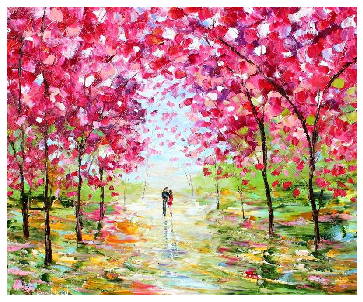

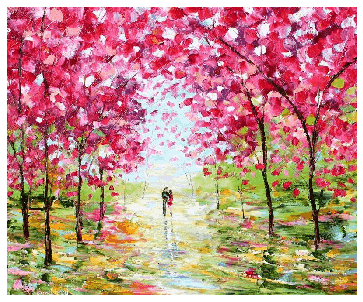

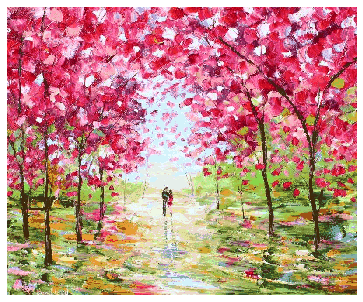

In [37]:
## 图片显示
plt.figure(u"原始图片",facecolor='w')
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
image_show = image * 255
if d == 1:
    plt.imshow(image, cmap=plt.cm.gray)
else:
    plt.imshow(image)

plt.figure(u'K-Means算法压缩图片',facecolor='w')
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
km_image = recreate_image(k_means.cluster_centers_, labels, w, h)
km_image.shape = original_shape
image_show = km_image * 255
if d == 1:
    plt.imshow(km_image, cmap=plt.cm.gray)
else:
    plt.imshow(km_image)

plt.figure(u'随机抽取像素点压缩图片',facecolor='w')
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
random_image = recreate_image(codebook_random, labels_random, w, h)
random_image.shape = original_shape
image_show = random_image * 255
if d == 1:
    plt.imshow(random_image, cmap=plt.cm.gray)
else:
    plt.imshow(random_image)
    
plt.show()

In [43]:
import imageio
imageio.imwrite('./datas/result_1.png', (image * 255).astype(np.uint8))
imageio.imwrite('./datas/result_2.png', (km_image * 255).astype(np.uint8))
imageio.imwrite('./datas/result_3.png', (random_image * 255).astype(np.uint8))